# Coursework1: Convolutional Neural Networks 

## instructions

Please submit a version of this notebook containing your answers **together with your trained model** on CATe as CW2.zip. Write your answers in the cells below each question.

### Setting up working environment 

For this coursework you will need to train a large network, therefore we recommend you work with Google Colaboratory, which provides free GPU time. You will need a Google account to do so. 

Please log in to your account and go to the following page: https://colab.research.google.com. Then upload this notebook.

For GPU support, go to "Edit" -> "Notebook Settings", and select "Hardware accelerator" as "GPU".

You will need to install pytorch by running the following cell:

In [2]:
!pip install torch torchvision

## Introduction

For this coursework you will implement one of the most commonly used model for image recognition tasks, the Residual Network. The architecture is introduced in 2015 by Kaiming He, et al. in the paper ["Deep residual learning for image recognition"](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/He_Deep_Residual_Learning_CVPR_2016_paper.pdf). 
<br>

In a residual network, each block contains some convolutional layers, plus "skip" connections, which allow the activations to by pass a layer, and then be summed up with the activations of the skipped layer. The image below illustrates a building block in residual networks.

![resnet-block](utils/resnet-block.png)

Depending on the number of building blocks, resnets can have different architectures, for example ResNet-50, ResNet-101 and etc. Here you are required to build ResNet-18 to perform classification on the CIFAR-10 dataset, therefore your network will have the following architecture:

![resnet](utils/resnet.png)

## Part 1 (40 points)

In this part, you will use basic pytorch operations to define the 2D convolution, max pooling operation, linear layer as well as 2d batch normalization. 

### YOUR TASK

- implement the forward pass for Conv2D, MaxPool2D, Linear and BatchNorm2d
- You are **NOT** allowed to use the torch.nn modules

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Conv2d(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 stride=1,
                 padding=0,
                 bias=True):

        super(Conv2d, self).__init__()
        """
        An implementation of a convolutional layer.

        The input consists of N data points, each with C channels, height H and
        width W. We convolve each input with F different filters, where each filter
        spans all C channels and has height HH and width WW.

        Parameters:
        - w: Filter weights of shape (F, C, HH, WW)
        - b: Biases, of shape (F,)
        - kernel_size: Size of the convolving kernel
        - stride: The number of pixels between adjacent receptive fields in the
            horizontal and vertical directions.
        - padding: The number of pixels that will be used to zero-pad the input.
        """

        ########################################################################
        # TODO: Define the parameters used in the forward pass                 #
        ########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        # If kernel size is integer then width and height are the same... 
        if isinstance(kernel_size,int):
          self.hh = kernel_size
          self.ww = kernel_size
        # ... else kernel_size will be list/tuple with height first and width 
        # second
        else:
          self.hh = kernel_size[0]
          self.ww = kernel_size[1]

        # Define some parameters 
        self.c_out = out_channels
        self.c_in = in_channels
        self.pad = padding
        self.stride = stride
        self.f = self.c_out
        self.bias = bias

        # Set the weight matrix. Here I just make the values random in the 
        # weights between 0 and 5. Could be anything though. 

        self.w = torch.randint(0,5,(self.f,self.c_in,self.hh,self.ww))
        #print(f'weight is: {self.w}')
        # self.w = torch.tensor([[1,0,1],[0,1,0],[1,0,1]])

        # If bias == True then set a random bias
        if self.bias:
          self.b = torch.randint(0,5,(self.f,))

        #print(f' bias is {self.b}')


        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

    def forward(self, x):
        """
        Input:
        - x: Input data of shape (N, C, H, W)
        Output:
        - out: Output data, of shape (N, F, H', W').
        """

        ########################################################################
        # TODO: Implement the forward pass                                     #
        ########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        # make sure the C in the weight matrix is the same as the C in the input
        # x
        assert(x.shape[1] == self.c_in)

        # define some variables from input x
        c_in = x.shape[1]
        n = x.shape[0]
        h = x.shape[2]
        w = x.shape[3]

        self.c_out = self.w.shape[0]

        # Make some calculations so that we can do convultion
        out_h = int((h - self.hh + 2*self.pad)/self.stride)+1
        out_w = int((w - self.ww + 2*self.pad)/self.stride)+1

        # initialise the output with zeros in correct dimension
        out = torch.zeros((n, self.f, out_h, out_w))

        # now pad the input matrix x if padding is required
        x = F.pad(input=x, pad=(self.pad, self.pad, self.pad, self.pad), mode='constant', value=0)

        # for loop to carry out convolution of input matrix and weight matrix to 
        # give output matrix

        for i in range(n):
          x_prev = x[i]
          for h in range(0,out_h,self.stride):
            for w in range(out_w):
              for c in range(self.f):
                vert_start = h*self.stride
                vert_end = vert_start + self.hh
                horiz_start = w*self.stride
                horiz_end = horiz_start + self.ww

                x_slice = x_prev[:,vert_start:vert_end,horiz_start:horiz_end]

                s = x_slice*self.w[:,c,:,:]
                out[i,c,h,w] = torch.sum(s)

                # If bias == True then add the bias matrix
                if self.bias:
                  out[i,c,h,w] += torch.sum(self.b)

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

        return out

# Some practice code to make sure I have the correct code

convolution = Conv2d(1,1,3)
x = torch.randint(0,10,(1,1,5,5))
#print(f' x is {x}')
print(convolution.forward(x))



tensor([[[[118., 138., 107.],
          [ 93., 112., 131.],
          [111., 132.,  96.]]]])


In [4]:
class MaxPool2d(nn.Module):
    def __init__(self, kernel_size):
        super(MaxPool2d, self).__init__()
        """
        An implementation of a max-pooling layer.

        Parameters:
        - kernel_size: the size of the window to take a max over
        """
        ########################################################################
        # TODO: Define the parameters used in the forward pass                 #
        ########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        if isinstance(kernel_size, int):
          self.hh = kernel_size
          self.ww = kernel_size
        else:
          self.hh = kernel_size[0]
          self.ww = kernel_size[1]

        self.stride = 1


        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

    def forward(self, x):
        """
        Input:
        - x: Input data of shape (N, C, H, W)
        Output:
        - out: Output data, of shape (N, F, H', W').
        """
        ########################################################################
        # TODO: Implement the forward pass                                     #
        ########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        # Define parameters from the input tensor x
        c_in = x.shape[1]
        n = x.shape[0]
        h = x.shape[2]
        w = x.shape[3]

        # Define where we are going to take the max pool over 

        out_h = int((h - self.hh)/self.stride)+1
        out_w = int((w - self.ww)/self.stride)+1

        # initialise the output tensor

        out = torch.zeros((n, c_in, out_h, out_w))

        # find the maximum value over the kernel of the input tensor

        for i in range(n):
          for j in range(out_h):
            for k in range(out_w):
              for c in range(c_in):
                vert_start = j*self.stride
                vert_end = j + self.hh
                horiz_start = k*self.stride
                horiz_end = k + self.ww

                # Assign the value to the output tensor

                x_slice = x[i,c,vert_start:vert_end,horiz_start:horiz_end]
                out[i, c, j, k] = torch.max(x_slice)

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

        return out

max_pool = MaxPool2d(3)
x = torch.randint(0,10,(1,1,5,5))
print(x)
print(max_pool.forward(x))


tensor([[[[9, 8, 5, 1, 7],
          [4, 9, 5, 4, 8],
          [7, 4, 8, 1, 4],
          [6, 5, 9, 2, 9],
          [8, 4, 2, 6, 0]]]])
tensor([[[[9., 9., 8.],
          [9., 9., 9.],
          [9., 9., 9.]]]])


In [5]:
class Linear(nn.Module):
    def __init__(self, in_channels, out_channels, bias=True):
        super(Linear, self).__init__()
        """
        An implementation of a Linear layer.

        Parameters:
        - weight: the learnable weights of the module of shape (in_channels, out_channels).
        - bias: the learnable bias of the module of shape (out_channels).
        """
        ########################################################################
        # TODO: Define the parameters used in the forward pass                 #
        ########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.bias = bias

        # Here I use nn.Parameter to initialise the weights and bias. They could 
        # be initialised randomely or with a normal distribution as above, but I 
        # wanted to see what nn.Parameter does. If this isn't good you can always 
        # set the weights and bias to be random/normally distributed. 

        self.weight = torch.nn.Parameter(torch.Tensor(out_channels, in_channels))
        if self.bias:
          self.b = torch.nn.Parameter(torch.Tensor(out_channels))
          
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

    def forward(self, x):
        """
        Input:
        - x: Input data of shape (N, *, H) where * means any number of additional
        dimensions and H = in_channels
        Output:
        - out: Output data of shape (N, *, H') where * means any number of additional
        dimensions and H' = out_channels
        """
        ########################################################################
        # TODO: Implement the forward pass                                     #
        ########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        # Make sure that the shapes match
        if x.shape[-1] != self.in_channels:
          print(f'the input is of the wrong shape')
          return f'the input is of the wrong shape'

        # Apply the Linear Layer calculations using torch matrix multiplication

        out = x.matmul(self.weight.t())

        # Add the bias is bias == true
        if self.bias:
          out += self.b
        

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

        return out

linear_model = Linear(3,5)
x = torch.randn(2,1,3)
print(linear_model.forward(x))

tensor([[[ 2.9289e-35,         nan,  5.3897e+21,  7.9880e+28,  3.2170e+22]],

        [[ 4.1833e-35,         nan, -3.3528e+21, -4.9692e+28, -1.5337e+22]]],
       grad_fn=<AddBackward0>)


In [6]:
class BatchNorm2d(nn.Module):
    def __init__(self, num_features, eps=1e-05, momentum=0.1):
        super(BatchNorm2d, self).__init__()
        """
        An implementation of a Batch Normalization over a mini-batch of 2D inputs.

        The mean and standard-deviation are calculated per-dimension over the
        mini-batches and gamma and beta are learnable parameter vectors of
        size num_features.

        Parameters:
        - num_features: C from an expected input of size (N, C, H, W).
        - eps: a value added to the denominator for numerical stability. Default: 1e-5
        - momentum: momentum – the value used for the running_mean and running_var
        computation. Default: 0.1
        - gamma: the learnable weights of shape (num_features).
        - beta: the learnable bias of the module of shape (num_features).
        """
        ########################################################################
        # TODO: Define the parameters used in the forward pass                 #
        ########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        self.momentum = momentum 
        self.eps = eps
        self.num_features = num_features 
        # Set variables to see if we are in training mode 
        self.training = True 

        # Define gamma as weights and beta as bias and initialise them

        # I used nn.Parameter here but we could assign them to be random or 
        # follow a normal distribution. I kind of just wanted to see what 
        # nn.Parameter does... it gives slightly weird results.
        # gamma and beta could be initialised to anything though. 
        
        self.gamma = nn.Parameter(torch.Tensor(num_features,1,1))
        self.beta  = nn.Parameter(torch.Tensor(num_features,1,1))
        print(self.gamma)
        print(self.beta)


        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

    def forward(self, x):
        """
        During training this layer keeps running estimates of its computed mean and
        variance, which are then used for normalization during evaluation.
        Input:
        - x: Input data of shape (N, C, H, W)
        Output:
        - out: Output data of shape (N, C, H, W) (same shape as input)
        """
        ########################################################################
        # TODO: Implement the forward pass                                     #
        #       (be aware of the difference for training and testing)          #
        ########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        # If training mode is True 
        if self.training:
          mean = x.mean([0,2,3])
          var = x.var([0,2,3],unbiased = False)
          print(f' mean is {mean}')
          print(f'var is {var}')
          n = x.numel()/x.size(1)
          print(n)
          # initialise running mean and running var
          self.running_mean = torch.zeros(self.num_features)
          self.running_var = torch.ones(self.num_features)
          with torch.no_grad():
            self.running_mean = self.momentum*mean+(1 - self.momentum)*self.running_mean
            self.running_var = self.momentum*var*(n/(n-1))+(1-self.momentum)*self.running_var
            print(f' running mean is {self.running_mean}')
            print(f' running var is {self.running_var}')
        # If testing mode is True 
        else:
          mean = self.running_mean
          var = self.running_var

        # Do the batch normalisation algorthm on x

        x = (x - self.running_mean[None, :, None, None])/(torch.sqrt(self.running_var[None,:,None,None] + self.eps))
        x = x*self.gamma[None,:,None,None] + self.beta[None,:,None,None]

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

        return x
norm = BatchNorm2d(1)
x = torch.randint(0,10,(1,1,5,5)).float()
print(x)
norm.forward(x)

Parameter containing:
tensor([[[2.4327e-35]]], requires_grad=True)
Parameter containing:
tensor([[[2.4328e-35]]], requires_grad=True)
tensor([[[[8., 0., 4., 9., 2.],
          [8., 0., 5., 0., 0.],
          [5., 4., 0., 8., 4.],
          [4., 3., 6., 0., 3.],
          [0., 8., 8., 9., 5.]]]])
 mean is tensor([4.1200])
var is tensor([10.1856])
25.0
 running mean is tensor([0.4120])
 running var is tensor([1.9610])


tensor([[[[[[1.5615e-34, 1.7170e-35, 8.6659e-35, 1.7352e-34, 5.1915e-35],
            [1.5615e-34, 1.7170e-35, 1.0403e-34, 1.7170e-35, 1.7170e-35],
            [1.0403e-34, 8.6659e-35, 1.7170e-35, 1.5615e-34, 8.6659e-35],
            [8.6659e-35, 6.9287e-35, 1.2140e-34, 1.7170e-35, 6.9287e-35],
            [1.7170e-35, 1.5615e-34, 1.5615e-34, 1.7352e-34, 1.0403e-34]]]]]],
       grad_fn=<AddBackward0>)

## Part 2

In this part, you will train a ResNet-18 defined on the CIFAR-10 dataset. Code for training and evaluation are provided. 

### Your Task

1. Train your network to achieve the best possible test set accuracy after a maximum of 10 epochs of training.

2. You can use techniques such as optimal hyper-parameter searching, data pre-processing

3. If necessary, you can also use another optimizer

4. **Answer the following question:**
Given such a network with a large number of trainable parameters, and a training set of a large number of data, what do you think is the best strategy for hyperparameter searching? 

When we have a training set with a large amount of data and a large number of trainable parameters and we use a grid search type algorithm to find the best parameters, it takes a very long time to check all of them and assess their effect on the accuracy of our model. This is because a Grid Search suffers from the curse of dimensionality. Therefore this is not the best strategy to search for the best hyper parameters. Additionally, we could do a Random Search to find the best hyperparameters such that the search is not so exhaustive but we still check a large amount of hyperparameters. This is less computationally expensive than the grid search, but we may not get as good results. A different strategy that we could follow is Bayesian optimisation. When we apply Bayesian optimiasation to hyper parameter searching, we build a probabilistic model of the function mapping from hyperparameter values to the accuracy of our model on the validation set. Bayesian optimisation means that we can predict beforehand which hyperparameters will give the best results, therefore will perform better than both the grid search and the random search and will not be as computationally expensive.

In [0]:
import torch
from torch.nn import Conv2d, MaxPool2d
import torch.nn as nn
import torch.nn.functional as F

Next, we define ResNet-18:

In [0]:
# define resnet building blocks

class ResidualBlock(nn.Module): 
    def __init__(self, inchannel, outchannel, stride=1): 
        
        super(ResidualBlock, self).__init__() 
        
        self.left = nn.Sequential(Conv2d(inchannel, outchannel, kernel_size=3, 
                                         stride=stride, padding=1, bias=False), 
                                  nn.BatchNorm2d(outchannel), 
                                  nn.ReLU(inplace=True), 
                                  Conv2d(outchannel, outchannel, kernel_size=3, 
                                         stride=1, padding=1, bias=False), 
                                  nn.BatchNorm2d(outchannel)) 
        
        self.shortcut = nn.Sequential() 
        
        if stride != 1 or inchannel != outchannel: 
            
            self.shortcut = nn.Sequential(Conv2d(inchannel, outchannel, 
                                                 kernel_size=1, stride=stride, 
                                                 padding = 0, bias=False), 
                                          nn.BatchNorm2d(outchannel) ) 
            
    def forward(self, x): 
        
        out = self.left(x) 
        
        out += self.shortcut(x) 
        
        out = F.relu(out) 
        
        return out


    
    # define resnet

class ResNet(nn.Module):
    
    def __init__(self, ResidualBlock, num_classes = 10, kernel_size = 3, dropout = 0.2):
        
        super(ResNet, self).__init__()
        
        self.inchannel = 64
        self.dropout = dropout
        self.conv1 = nn.Sequential(Conv2d(3, 64, kernel_size = kernel_size, stride = 1,
                                            padding = 1, bias = False), 
                                  nn.BatchNorm2d(64), 
                                  nn.ReLU())
        
        self.layer1 = self.make_layer(ResidualBlock, 64, 2, stride = 1)
        self.layer2 = self.make_layer(ResidualBlock, 128, 2, stride = 2)
        self.layer3 = self.make_layer(ResidualBlock, 256, 2, stride = 2)
        self.layer4 = self.make_layer(ResidualBlock, 512, 2, stride = 2)
        self.maxpool = MaxPool2d(4)
        self.fc = nn.Linear(512, num_classes)

        
    
    def make_layer(self, block, channels, num_blocks, stride):
        
        strides = [stride] + [1] * (num_blocks - 1)
        
        layers = []
        
        for stride in strides:
            
            layers.append(block(self.inchannel, channels, stride))
            
            self.inchannel = channels

        # I added in some dropout here... so that when we use a low learning rate
        # the model doesn't over-fit and we get better accuracy.
            
        return nn.Sequential(*layers, nn.Dropout(self.dropout))
    
    
    def forward(self, x):
        
        x = self.conv1(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.maxpool(x)
        
        x = x.view(x.size(0), -1)
        
        x = self.fc(x)
        
        return x
    
    
def ResNet18(kernel_size = 3, dropout = 0.2):
    return ResNet(ResidualBlock, kernel_size=kernel_size, dropout = dropout)

### Loading dataset
We will import images from the [torchvision.datasets](https://pytorch.org/docs/stable/torchvision/datasets.html) library <br>
First, we need to define the alterations (transforms) we want to perform to our images - given that transformations are applied when importing the data. <br>
Define the following transforms using the torchvision.datasets library -- you can read the transforms documentation [here](https://pytorch.org/docs/stable/torchvision/transforms.html): <br>
1. Convert images to tensor
2. Normalize mean and std of images with values:mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010]

In [0]:
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset

import numpy as np

import torchvision.transforms as T

##############################################################
#                       YOUR CODE HERE                       #       
##############################################################
# transform = T.Compose([
#                 T.ToTensor(),
#                 T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
#             ])

# The commented out code above is a transform that only does normalisation and 
# changes images to tensor, but I wanted to go further with data augmentation which 
# is done below. 

# Here I also use random flips of images, rotation and some altering of colors to 
# add some data augmentation to the training data. I also introduce validation data. 

transform = {
    # Train uses data augmentation
    'train':
    T.Compose([
        T.RandomRotation(degrees=15),
        T.ColorJitter(),
        T.RandomHorizontalFlip(),
        T.ToTensor(),
        T.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2023, 0.1994, 0.2010)) 
    ]),
    # Validation does not use augmentation
    'val':
    T.Compose([
        T.ToTensor(),
        T.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2023, 0.1994, 0.2010))
    ]),
    # Test does not use augmentation
    'test':
    T.Compose([
        T.ToTensor(),
        T.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2023, 0.1994, 0.2010))
    ]),
}

##############################################################
#                       END OF YOUR CODE                     #
##############################################################




Now load the dataset using the transform you defined above, with batch_size = 64<br>
You can check the documentation [here](https://pytorch.org/docs/stable/torchvision/datasets.html)
Then create data loaders (using DataLoader from torch.utils.data) for the training and test set

In [10]:

##############################################################
#                       YOUR CODE HERE                       #       
##############################################################

data_dir = './data'

NUM_TRAIN = 49000

cifar10_train = dset.CIFAR10(data_dir, train=True, download=True,
                             transform=transform['train'])
loader_train = DataLoader(cifar10_train, batch_size=64, 
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

cifar10_val = dset.CIFAR10(data_dir, train=True, download=True,
                           transform=transform['val'])
loader_val = DataLoader(cifar10_val, batch_size=64, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 50000)))

cifar10_test = dset.CIFAR10(data_dir, train=False, download=True, 
                            transform=transform['test'])
loader_test = DataLoader(cifar10_test, batch_size=64)


##############################################################
#                       END OF YOUR CODE                     #       
##############################################################



Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified


In [0]:
USE_GPU = True
dtype = torch.float32 

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
    

print_every = 100
def check_accuracy(loader, model):
    # function for test accuracy on validation and test set
    
    if loader.dataset.train:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')   
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))

        # I add in a return so that in the next section I can compare different model's
        # accuracies very easily
        
        return acc*100

        

def train_part(model, optimizer, epochs=1):
    """
    Train a model on CIFAR-10 using the PyTorch Module API.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        print(len(loader_train))
        for t, (x, y) in enumerate(loader_train):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            loss.backward()

            # Update the parameters of the model using the gradients
            optimizer.step()

            if t % print_every == 0:
                print('Epoch: %d, Iteration %d, loss = %.4f' % (e, t, loss.item()))
                check_accuracy(loader_val, model)
                print()



In [15]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [18]:
# code for optimising your network performance

##############################################################
#                       YOUR CODE HERE                       #       
##############################################################

# Here I change selected hyperparameters: the dropout and the learning rate.

kernel_size_params = [3] 
# changed the kernel size to begin with but kept it at 3
# because of an answer on piazza.

# change the value of the dropout also

dropout = [0.1, 0.2]

# Update the values of the learning rate used in the optimizer
lr = [0.0005, 0.001]

##############################################################
#                       END OF YOUR CODE                     #
##############################################################

check_accuracy_prev = 0

# define and train the network
for i in range(len(kernel_size_params)):
  for item in lr:
    for rate in dropout:
      model = ResNet18(kernel_size = kernel_size_params[i])
      optimizer = optim.Adam(model.parameters(), lr = item)

      train_part(model, optimizer, epochs = 10)


      # report test set accuracy

      check_accuracy(loader_test, model)
      # Save the best model... i.e the one that gives the best test accuracy
      if check_accuracy(loader_test, model) > check_accuracy_prev:
        model_save_name = 'model.pt'
        path = F"/content/gdrive/My Drive/{model_save_name}" 
        torch.save(model.state_dict(), path)
        # files.download('model.pt')
      check_accuracy_prev = check_accuracy(loader_test, model)

  # save the model
#torch.save(model.state_dict(), 'model.pt')

766
Epoch: 0, Iteration 0, loss = 3.6364
Checking accuracy on validation set
Got 110 / 1000 correct (11.00)

Epoch: 0, Iteration 100, loss = 1.7955
Checking accuracy on validation set
Got 364 / 1000 correct (36.40)

Epoch: 0, Iteration 200, loss = 1.9690
Checking accuracy on validation set
Got 426 / 1000 correct (42.60)

Epoch: 0, Iteration 300, loss = 1.4695
Checking accuracy on validation set
Got 470 / 1000 correct (47.00)

Epoch: 0, Iteration 400, loss = 1.3182
Checking accuracy on validation set
Got 513 / 1000 correct (51.30)

Epoch: 0, Iteration 500, loss = 1.5107
Checking accuracy on validation set
Got 506 / 1000 correct (50.60)

Epoch: 0, Iteration 600, loss = 1.4717
Checking accuracy on validation set
Got 530 / 1000 correct (53.00)

Epoch: 0, Iteration 700, loss = 1.1504
Checking accuracy on validation set
Got 550 / 1000 correct (55.00)

766
Epoch: 1, Iteration 0, loss = 1.0892
Checking accuracy on validation set
Got 591 / 1000 correct (59.10)

Epoch: 1, Iteration 100, loss = 1

## Part 3

The code provided below will allow you to visualise the feature maps computed by different layers of your network. Run the code (install matplotlib if necessary) and **answer the following questions**: 

1. Compare the feature maps from low-level layers to high-level layers, what do you observe? 

The feature maps become more complex as we move from the low-level layers to the high-level layers. By complex I mean there are more colours in the high-level layers, and the patterns are a bit more complicated. This is because the lower level layers are trying to find features from the input layer, then subsequent layers are trying to find less obvious features. The layers need to find features so that they can train and learn which features are mapped to certain labels. The lower-levels seem to find the obvious features, then the higher-levels seem to be the ones that provide the necessary information to appropriately classify each feature. 

2. Use the training log, reported test set accuracy and the feature maps, analyse the performance of your network. If you think the performance is sufficiently good, explain why; if not, what might be the problem and how can you improve the performance?

From my traning log I see that the accuracy of my best model on the validation set gets up to around 88% and the best accuracy on the test data that I had was around 87%. This is a sufficiently good model as it correctly classifies the image 85%-87% of the time. Additionally, from the traning log I see that the accuracy of the model on the validation set keeps on increasing up to the tenth epoch. Therefore if we trained the model for longer it would have an even better accuracy. The accuracy is sufficiently good because the architecture of the network is suitable for the task, I have used data augmentation to improve results, and also I have introduced a select few hyperparameters such as learning rate and dropout such that we can choose the best model. Dropout is important as I realised in a few models that my accuracy on the validation data was substantially higher than the accuracy on the test data. Therefore the model was most likely over-fitting, so I introduced dropout to limit this from happening. I could improve my performance by using Bayesian optimisation to search for the best hyper-parameters, and also I could have chosen many other paramaters to alter. In the end I just manually changed hyperparameters and then chose the ones that gave the best results. This is not quite an exhaustive search so I may have missed a crucial combination that would have upped my accuracy significantly. I also may have been able to improve my performance by using 10-fold cross validation. Even though I had a lot of data, cross validation could have worked by giving us more data to work with and also a technique to find better hyperparameters. The feature maps of my model seem good as each layer is recognising different features of the image and is classifying them well. 

3. What are the other possible ways to analyse the performance of your network?

We could use other metrics to analyse the performance of our network. For example, we could use a confusion matrix, recall, precision and f1 scores. A confusion matrix would be useful as we could easily visualise which labels are being confused with other labels. For example, our network may have a very high accuracy score overall, but could misclassify a certain type of image all the time. The confusion matrix would let us know what labels our network is good at classifying, and what lables our network is bad at classifying. The f1 scores, recall and precision would also help in analysing the performance of our network.

**YOUR ANSWER FOR PART 3 HERE**

A: I wrote the answers directly above, underneath each question.

<Figure size 432x288 with 0 Axes>

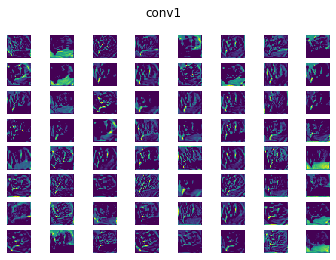

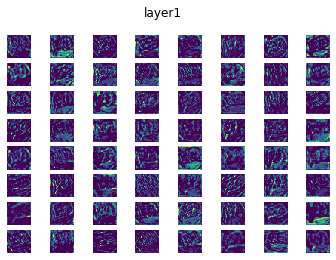

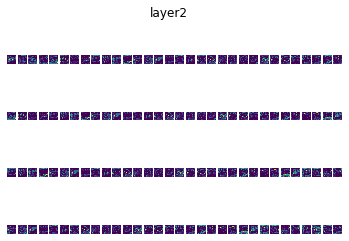

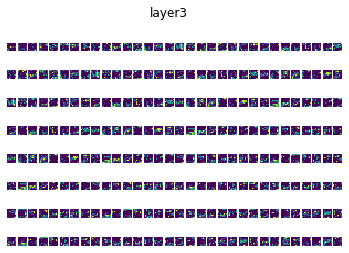

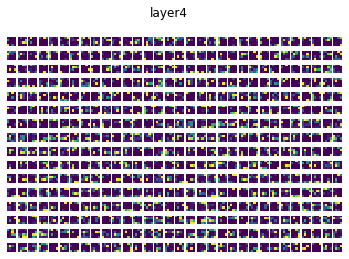

In [0]:
#!pip install matplotlib

import matplotlib.pyplot as plt

plt.tight_layout()


activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

vis_labels = ['conv1', 'layer1', 'layer2', 'layer3', 'layer4']

for l in vis_labels:

    getattr(model, l).register_forward_hook(get_activation(l))
    
    
data, _ = cifar10_test[0]
data = data.unsqueeze_(0).to(device = device, dtype = dtype)

output = model(data)



for idx, l in enumerate(vis_labels):

    act = activation[l].squeeze()

    if idx < 2:
        ncols = 8
    else:
        ncols = 32
        
    nrows = act.size(0) // ncols
    
    fig, axarr = plt.subplots(nrows, ncols)
    fig.suptitle(l)


    for i in range(nrows):
        for j in range(ncols):
            axarr[i, j].imshow(act[i * nrows + j].cpu())
            axarr[i, j].axis('off')